In [1]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from torch.distributions import Normal

import random
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import celluloid
# import seaborn as sns

save = False

from os.path import expanduser

from franka.franka_utils import *

    
save = False
path = os.getcwd()
# Use this path if Loading Dataset
int_dir = os.path.dirname(path) 
home = os.path.dirname(int_dir) + "/data/grayscale/data/"
print(home)


/media/ahalya/Elements/data/sensor_learning/final_data_zenodo/data/grayscale/data/


In [2]:
klerg_dir = home + 'random_ic_comp/klerg/'
random_dir = home + 'random_ic_comp/random/'
im_dir = home + 'random_ic_comp/im_alg/'

In [3]:
# Load test data

dir_path = home + "test_data/"
# Load Pickled Data
file_path = dir_path + "data_eval_dict.pickle"
print(file_path) 
with open(file_path, 'rb') as f: 
    data_dict = pickle.load(f, encoding="bytes")
    print(data_dict.keys())
testobj1 = data_dict['obj_loc']
testobj2 = data_dict['obj2_loc']
testtraj = data_dict['path']
testbuffer = data_dict['buffer']
test_env_traj = data_dict['env_path']
test_env_lim = data_dict['tray_lim']
test_klerg_lim = data_dict['klerg_lim']
print(testobj1, testobj2)

/media/ahalya/Elements/data/sensor_learning/final_data_zenodo/data/grayscale/data/test_data/data_eval_dict.pickle
dict_keys(['path', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'tray_lim', 'klerg_lim'])
(-0.1, -0.1, -0.4) (0.1, -0.1, -0.6)


In [4]:
def mseloss(A,B): return np.square(np.subtract(A, B)).mean()

klerg_loss = []
random_loss = []
im_loss = []

for ic in range(10):
    print("IC:", ic)
    dir_path1 = klerg_dir + '0' + str(ic) + '/'
    dir_path2 = random_dir + '0' + str(ic) + '/'    
    dir_path3 = im_dir + '0' + str(ic) + '/'
    
    # Load Pytorch Models
    # model1 = torch.load("model_int_check.pth")
    model1 = torch.load(dir_path1 + "model_final_postlearning.pth")
    model1.eval()


    # Load Pytorch Models
    # model2 = torch.load("model_int_check.pth")
    model2 = torch.load(dir_path2 + "model_final_postlearning.pth")
    model2.eval()


    # Load Pytorch Models
    # model2 = torch.load("model_int_check.pth")
    model3 = torch.load(dir_path3 + "model_final_postlearning.pth")
    model3.eval()
    
    loss1 = []
    loss2 = []
    loss3 = []
    mseloss1 = [None]*len(testbuffer)
    mseloss2 = [None]*len(testbuffer)
    mseloss3 = [None]*len(testbuffer)

    with torch.no_grad():
        for cp in range(50,15400,50):
            PATH =  dir_path1 + "model_checkpoint_iter"+str(cp)+".pth"
            model1.load_state_dict(torch.load(PATH)['state_dict'])
            model1.eval()

            PATH =  dir_path2 + "model_checkpoint_iter"+str(cp)+".pth"
            model2.load_state_dict(torch.load(PATH)['state_dict'])
            model2.eval()

            PATH =  dir_path3 + "model_checkpoint_iter"+str(cp)+".pth"
            model3.load_state_dict(torch.load(PATH)['state_dict'])
            model3.eval()

            xt = np.expand_dims(testbuffer[0][0], axis=0)
            yt = np.expand_dims(np.mean(testbuffer[0][1][:,::2,::2],axis=0).flatten(), axis=0)

            xt = torch.FloatTensor(xt)#.squeeze()
            yt = torch.FloatTensor(yt)#.squeeze()
            _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
            z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

            _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
            z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

            _, _ , z_mu3, z_logvar3, _ = model3(xt, yt)
            z_samples3 = model3.reparameterize(z_mu3, z_logvar3)

            ind = 0
            for i in range(int(len(testbuffer)/2)):

                xc = np.expand_dims(testbuffer[ind][0], axis=0)
                xc = torch.FloatTensor(xc)#.squeeze()

                y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
                img_pred1 = y_pred[:,1:]
                ycheck1 = img_pred1[0].detach().numpy().reshape((38,38)).T
                mseloss1[ind] = mseloss(ycheck1, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)


                y_pred = model2.decode(torch.cat([z_samples2, xc], dim=1))
                img_pred2 = y_pred[:,1:]
                ycheck2 = img_pred2[0].detach().numpy().reshape((38,38)).T
                mseloss2[ind] = mseloss(ycheck2, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)

                y_pred = model3.decode(torch.cat([z_samples3, xc], dim=1))
                img_pred3 = y_pred[:,1:]
                ycheck3 = img_pred3[0].detach().numpy().reshape((38,38)).T
                mseloss3[ind] = mseloss(ycheck3, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)
                ind +=1

            xt = np.expand_dims(testbuffer[ind][0], axis=0)
            yt = np.expand_dims(np.mean(testbuffer[ind][1][:,::2,::2],axis=0).flatten(), axis=0)

            xt = torch.FloatTensor(xt)#.squeeze()
            yt = torch.FloatTensor(yt)#.squeeze()

            _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
            z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

            _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
            z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

            _, _ , z_mu3, z_logvar3, _ = model3(xt, yt)
            z_samples3 = model3.reparameterize(z_mu3, z_logvar3)

            for i in range(int(len(testbuffer)/2)):
                xc = np.expand_dims(testbuffer[ind][0], axis=0)
                xc = torch.FloatTensor(xc)#.squeeze()

                y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
                img_pred1 = y_pred[:,1:]
                ycheck1 = img_pred1[0].detach().numpy().reshape((38,38)).T
                mseloss1[ind] = mseloss(ycheck1, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)

                y_pred = model2.decode(torch.cat([z_samples2, xc], dim=1))
                img_pred2 = y_pred[:,1:]
                ycheck2 = img_pred2[0].detach().numpy().reshape((38,38)).T
                mseloss2[ind] = mseloss(ycheck2, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)

                y_pred = model3.decode(torch.cat([z_samples3,xc], dim=1))
                img_pred3 = y_pred[:,1:]
                ycheck3 = img_pred3[0].detach().numpy().reshape((38,38)).T
                mseloss3[ind] = mseloss(ycheck3, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)

                ind += 1

            loss1.append(mseloss1.copy())
            loss2.append(mseloss2.copy())
            loss3.append(mseloss3.copy())
            
    loss1 = np.array(loss1)
    loss2 = np.array(loss2)
    loss3 = np.array(loss3)

    klerg_loss.append(loss1)
    random_loss.append(loss2)
    im_loss.append(loss3)
    

IC: 0
IC: 1
IC: 2
IC: 3
IC: 4
IC: 5
IC: 6
IC: 7
IC: 8
IC: 9


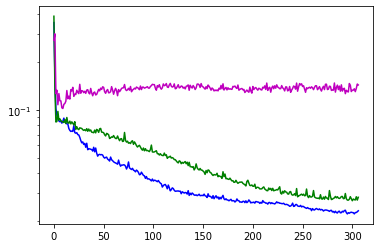

In [5]:
plt.semilogy(np.sum(loss1, axis=1), 'b')
plt.semilogy(np.sum(loss2, axis=1),'g')
plt.semilogy(np.sum(loss3, axis=1),'m')

if save: plt.savefig('figures/intensity/logtestinglossovertime.pdf')
plt.show()

In [6]:
klerg_loss = np.array(klerg_loss)
random_loss = np.array(random_loss)
im_loss = np.array(im_loss)

print(klerg_loss.shape)

(10, 307, 18)


In [7]:
klerg_cumloss = np.sum(klerg_loss, axis=2) 
random_cumloss = np.sum(random_loss, axis=2)
im_cumloss = np.sum(im_loss, axis=2)
print(klerg_cumloss.shape)

(10, 307)


In [8]:
klerg_mean = np.mean(klerg_cumloss, axis=0)
klerg_sd = np.std(klerg_cumloss, axis=0)

random_mean = np.mean(random_cumloss, axis=0)
random_sd = np.std(random_cumloss, axis=0)

im_mean = np.mean(im_cumloss, axis=0)
im_sd = np.std(im_cumloss, axis=0)


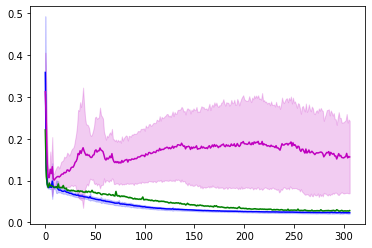

In [9]:
fig, ax = plt.subplots()
x = np.arange(len(klerg_mean))
ax.fill_between(x, klerg_mean-klerg_sd, klerg_mean+klerg_sd,color='b', alpha=0.2)
ax.plot(klerg_mean, 'b')

ax.fill_between(x, random_mean-random_sd, random_mean+random_sd,color='g', alpha=0.2)
ax.plot(random_mean, 'g')

ax.fill_between(x, im_mean-im_sd, im_mean+im_sd,color='m', alpha=0.2)
ax.plot(im_mean, 'm')
if save: plt.savefig('ic_comp_loss.pdf')
plt.show()

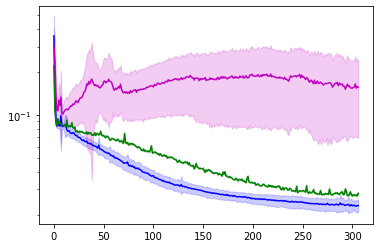

In [10]:
fig, ax = plt.subplots()
x = np.arange(len(klerg_mean))
ax.fill_between(x, klerg_mean-klerg_sd, klerg_mean+klerg_sd,color='b', alpha=0.2)
ax.plot(klerg_mean, 'b')

ax.fill_between(x, random_mean-random_sd, random_mean+random_sd,color='g', alpha=0.2)
ax.plot(random_mean, 'g')

ax.fill_between(x, im_mean-im_sd, im_mean+im_sd,color='m', alpha=0.2)
ax.plot(im_mean, 'm')
plt.yscale("log")
if save: plt.savefig('ic_comp_logloss.pdf')
plt.show()

In [12]:
klerg_paths = []
random_paths = []
im_paths = []

klerg_epaths = []
random_epaths = []
im_epaths = []



for ic in range(10):
    dir_path1 = klerg_dir + '0' + str(ic) + '/'
    dir_path2 = random_dir + '0' + str(ic) + '/'    
    dir_path3 = im_dir + '0' + str(ic) + '/'

    # Load Pickled Data
    file_path1 = dir_path1 + "data_eval_dict.pickle"
    with open(file_path1, 'rb') as f: 
        data_dict1 = pickle.load(f, encoding="bytes")
    traj1 = data_dict1['path']
    env_traj1 = data_dict1['env_path']
    klerg_paths.append(traj1)
    klerg_epaths.append(env_traj1)
    
    # Load Pickled Data
    file_path2 = dir_path2 + "data_eval_dict.pickle"
    with open(file_path2, 'rb') as f: 
        data_dict2 = pickle.load(f, encoding="bytes")
    traj2 = data_dict2['path']
    env_traj2 = data_dict2['env_path']
    random_paths.append(traj2)
    random_epaths.append(env_traj2)
    
    # Load Pickled Data
    file_path3 = dir_path3 + "data_eval_dict.pickle"
    with open(file_path3, 'rb') as f: 
        data_dict3 = pickle.load(f, encoding="bytes")
    traj3 = data_dict3['path']
    env_traj3 = data_dict3['env_path']
    im_paths.append(traj3)
    im_epaths.append(env_traj3)
  

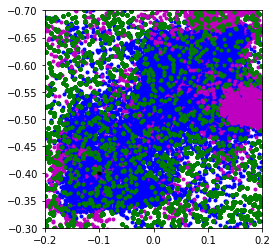

In [15]:
fig = plt.figure()
fig.patch.set_facecolor('white')
for ic in range(10):
    env_traj1 = klerg_epaths[ic]
    env_traj2 = random_epaths[ic]
    env_traj3 = im_epaths[ic]
    plt.plot(env_traj1[:,0], env_traj1[:,2],'b.')
    plt.plot(env_traj2[:,0], env_traj2[:,2],'g.')
    plt.plot(env_traj3[:,0], env_traj3[:,2],'m.')

plt.plot(testobj1[0], testobj1[2],'k.')
plt.plot(testobj2[0], testobj2[2],'g.')
# plt.plot(test_env_traj[:,0], test_env_traj[:,2], 'r.')
plt.axis('square')
plt.xlim(test_env_lim[0])
plt.ylim(test_env_lim[1])
if save: plt.savefig('ICTraj_comp1.pdf')
plt.show()

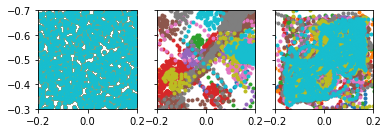

In [14]:
fig, ax = plt.subplots(1,3, sharey=True)
fig.patch.set_facecolor('white')
for ic in range(10):
    env_traj1 = klerg_epaths[ic]
    env_traj2 = random_epaths[ic]
    env_traj3 = im_epaths[ic]

    ax[0].plot(env_traj2[:,0], env_traj2[:,2], '.')
    ax[1].plot(env_traj3[:,0], env_traj3[:,2],'.')
    ax[2].plot(env_traj1[:,0], env_traj1[:,2],'.')

# plt.plot(test_env_traj[:,0], test_env_traj[:,2], 'r.')
ax[0].axis('square')
ax[1].axis('square')
ax[2].axis('square')

ax[0].set_xlim(test_env_lim[0])
ax[0].set_ylim(test_env_lim[1])
ax[1].set_xlim(test_env_lim[0])
ax[1].set_ylim(test_env_lim[1])
ax[2].set_xlim(test_env_lim[0])
ax[2].set_ylim(test_env_lim[1])
if save: plt.savefig('ic_traj.pdf')
plt.show()

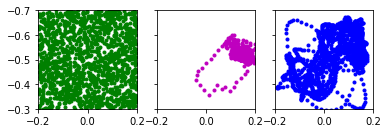

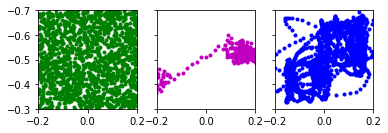

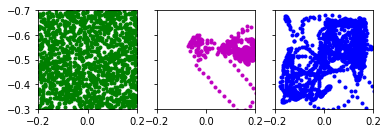

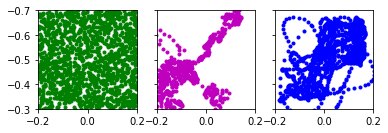

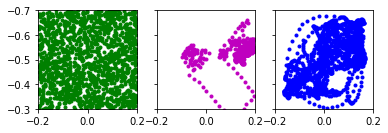

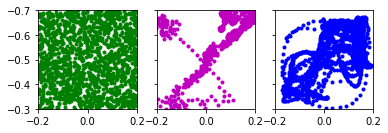

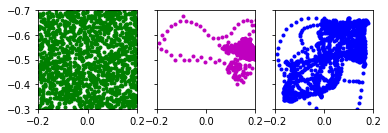

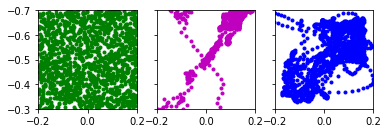

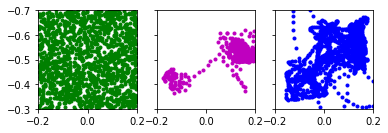

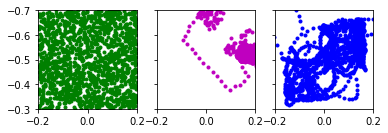

In [16]:

for ic in range(10):
    fig, ax = plt.subplots(1,3, sharey=True)
    fig.patch.set_facecolor('white')
    env_traj1 = klerg_epaths[ic]
    env_traj2 = random_epaths[ic]
    env_traj3 = im_epaths[ic]

    ax[0].plot(env_traj2[:,0], env_traj2[:,2], 'g.')
    ax[1].plot(env_traj3[:,0], env_traj3[:,2],'m.')
    ax[2].plot(env_traj1[:,0], env_traj1[:,2],'b.')

    # plt.plot(test_env_traj[:,0], test_env_traj[:,2], 'r.')
    ax[0].axis('square')
    ax[1].axis('square')
    ax[2].axis('square')

    ax[0].set_xlim(test_env_lim[0])
    ax[0].set_ylim(test_env_lim[1])
    ax[1].set_xlim(test_env_lim[0])
    ax[1].set_ylim(test_env_lim[1])
    ax[2].set_xlim(test_env_lim[0])
    ax[2].set_ylim(test_env_lim[1])
    if save: plt.savefig(str(ic)+'_ic_traj.pdf')
    plt.show()

In [17]:
klerg_energy = []
random_energy = []
im_energy = []
for ic in range(10):
    env_traj1 = klerg_epaths[ic]
    env_traj2 = random_epaths[ic]
    env_traj3 = im_epaths[ic]

    energy1 = [np.linalg.norm(env_traj1[i+1]-env_traj1[i]) for i in range(len(env_traj1)-1)]
    energy2 = [np.linalg.norm(env_traj2[i+1]-env_traj2[i]) for i in range(len(env_traj2)-1)]
    energy3 = [np.linalg.norm(env_traj3[i+1]-env_traj3[i]) for i in range(len(env_traj3)-1)]
    
    klerg_energy.append(energy1)
    random_energy.append(energy2)
    im_energy.append(energy3)
    
klerg_energy = np.array(klerg_energy)
random_energy = np.array(random_energy)
im_energy = np.array(im_energy)

klerg_energy = np.cumsum(klerg_energy, axis=1)
random_energy = np.cumsum(random_energy, axis=1)
im_energy = np.cumsum(im_energy,axis=1)

print(klerg_energy.shape, random_energy.shape, im_energy.shape)

(10, 1499) (10, 1499) (10, 1499)


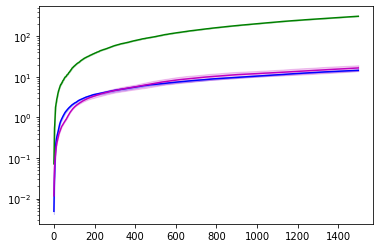

In [18]:
klerg_energy_mean = np.mean(klerg_energy, axis=0)
klerg_energy_sd = np.std(klerg_energy, axis=0)

random_energy_mean = np.mean(random_energy, axis=0)
random_energy_sd = np.std(random_energy, axis=0)

im_energy_mean = np.mean(im_energy, axis=0)
im_energy_sd = np.std(im_energy, axis=0)

fig, ax = plt.subplots()
x = np.arange(len(klerg_energy_mean))
ax.fill_between(x, klerg_energy_mean-klerg_energy_sd, klerg_energy_mean+klerg_energy_sd,color='b', alpha=0.2)
ax.plot(klerg_energy_mean, 'b')

ax.fill_between(x, random_energy_mean-random_energy_sd, random_energy_mean+random_energy_sd,color='g', alpha=0.2)
ax.plot(random_energy_mean, 'g')

ax.fill_between(x, im_energy_mean-im_energy_sd, im_energy_mean+im_energy_sd,color='m', alpha=0.2)
ax.plot(im_energy_mean, 'm')
plt.yscale("log")
if save: plt.savefig('ic_comp_logenergy.pdf')
plt.show()


In [51]:
from franka.franka_utils import *
ic = 0
dir_path1 = klerg_dir + '0' + str(ic) + '/'
dir_path2 = random_dir + '0' + str(ic) + '/'    
dir_path3 = im_dir + '0' + str(ic) + '/'

# Load Pytorch Models
# model1 = torch.load("model_int_check.pth")
model1 = torch.load(dir_path1 + "model_final_postlearning.pth")
model1.eval()


# Load Pytorch Models
# model2 = torch.load("model_int_check.pth")
model2 = torch.load(dir_path2 + "model_final_postlearning.pth")
model2.eval()


# Load Pytorch Models
# model2 = torch.load("model_int_check.pth")
model3 = torch.load(dir_path3 + "model_final_postlearning.pth")
model3.eval()

VAE(
  (encode): Sequential(
    (0): Linear(in_features=1446, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
  )
  (decode): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1445, bias=True)
  )
)

In [52]:
# Load test data

dir_path = home + "/data/sensor_learning/intensity_camera/data/test_data/"
# Load Pickled Data
file_path = dir_path + "data_eval_dict.pickle"
with open(file_path, 'rb') as f: 
    data_dict = pickle.load(f, encoding="bytes")
    print(data_dict.keys())
testobj1 = data_dict['obj_loc']
testobj2 = data_dict['obj2_loc']
testtraj = data_dict['path']
testbuffer = data_dict['buffer']
test_env_traj = data_dict['env_path']
test_env_lim = data_dict['tray_lim']
test_klerg_lim = data_dict['klerg_lim']
print(testobj1, testobj2)

dict_keys(['path', 'buffer', 'env_path', 'obj_loc', 'obj2_loc', 'tray_lim', 'klerg_lim'])
(-0.1, -0.1, -0.4) (0.1, -0.1, -0.6)


In [53]:
ycheck1 = [None]*len(testbuffer)
ycheck2 = [None]*len(testbuffer)
ycheck3 = [None]*len(testbuffer)

with torch.no_grad():
    xt = np.expand_dims(testbuffer[0][0], axis=0)
    yt = np.expand_dims(np.mean(testbuffer[0][1][:,::2,::2],axis=0).flatten(), axis=0)

    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()
    print(xt.shape, yt.shape)
    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

    _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
    z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

    _, _ , z_mu3, z_logvar3, _ = model3(xt, yt)
    z_samples3 = model3.reparameterize(z_mu3, z_logvar3)

    ind = 0
    for i in range(int(len(testbuffer)/2)):
        
        xc = np.expand_dims(testbuffer[ind][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()

        y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = y_pred[:,1:]
        ycheck1[ind] = img_pred1[0].detach().numpy().reshape((38,38)).T

        y_pred = model2.decode(torch.cat([z_samples2, xc], dim=1))
        img_pred2 = y_pred[:,1:]
        ycheck2[ind] = img_pred2[0].detach().numpy().reshape((38,38)).T

        y_pred = model3.decode(torch.cat([z_samples3, xc], dim=1))
        img_pred3 = y_pred[:,1:]
        ycheck3[ind] = img_pred3[0].detach().numpy().reshape((38,38)).T

        ind +=1
        
    print(ind)
    xt = np.expand_dims(testbuffer[ind][0], axis=0)
    yt = np.expand_dims(np.mean(testbuffer[ind][1][:,::2,::2],axis=0).flatten(), axis=0)

    xt = torch.FloatTensor(xt)#.squeeze()
    yt = torch.FloatTensor(yt)#.squeeze()

    _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
    z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

    _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
    z_samples2 = model2.reparameterize(z_mu2, z_logvar2)
    
    _, _ , z_mu3, z_logvar3, _ = model3(xt, yt)
    z_samples3 = model3.reparameterize(z_mu3, z_logvar3)

    for i in range(int(len(testbuffer)/2)):
        xc = np.expand_dims(testbuffer[ind][0], axis=0)
        xc = torch.FloatTensor(xc)#.squeeze()

        y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
        img_pred1 = y_pred[:,1:]
        ycheck1[ind] = img_pred1[0].detach().numpy().reshape((38,38)).T
        
        y_pred = model2.decode(torch.cat([z_samples2, xc], dim=1))
        img_pred2 = y_pred[:,1:]
        ycheck2[ind] = img_pred2[0].detach().numpy().reshape((38,38)).T

        y_pred = model3.decode(torch.cat([z_samples3, xc], dim=1))
        img_pred3 = y_pred[:,1:]
        ycheck3[ind] = img_pred3[0].detach().numpy().reshape((38,38)).T

        ind += 1
print(ind)

torch.Size([1, 2]) torch.Size([1, 1444])
9
18


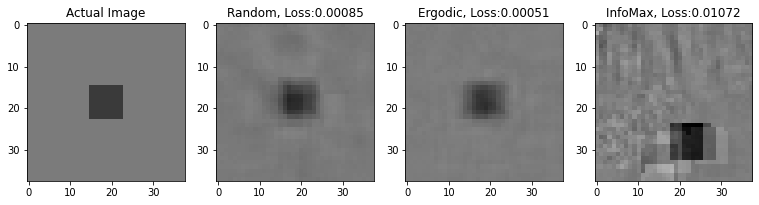

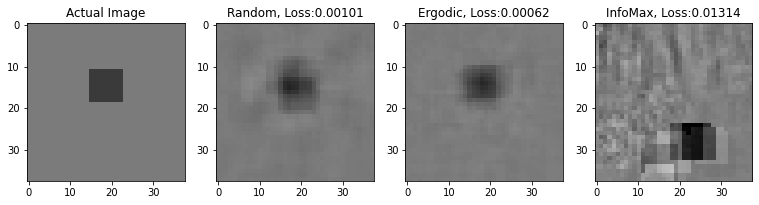

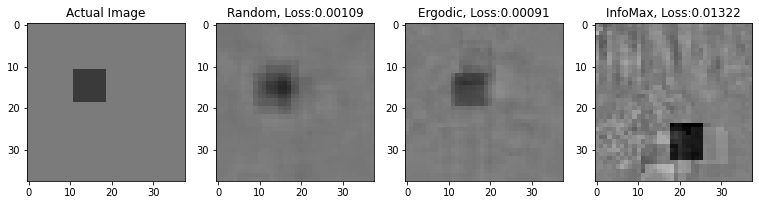

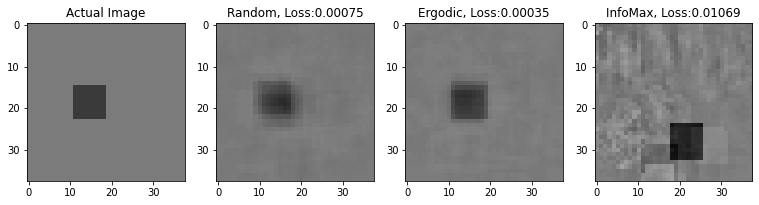

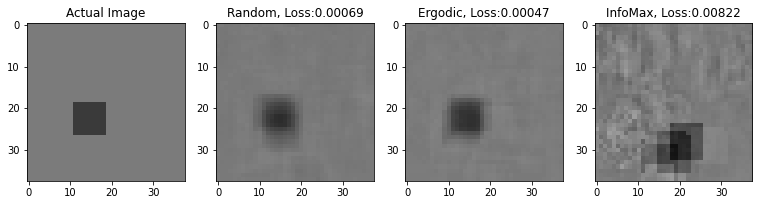

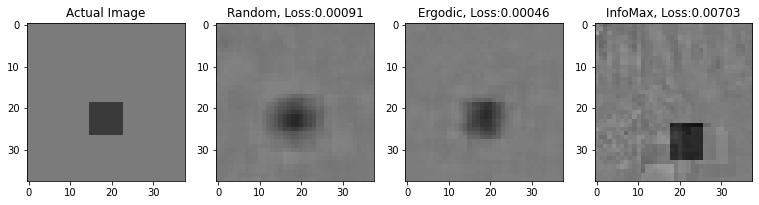

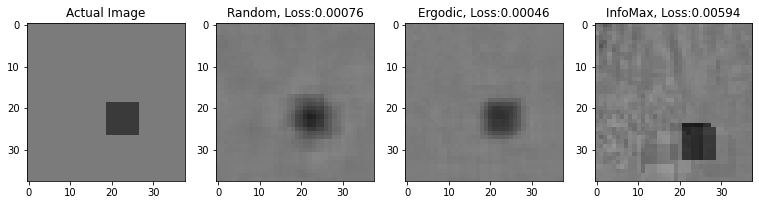

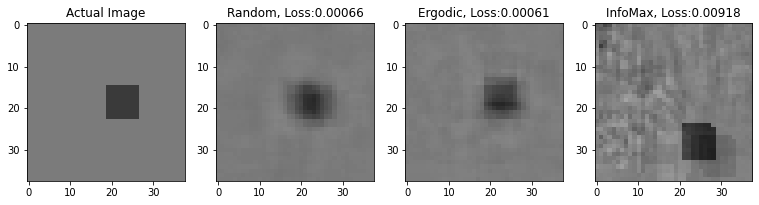

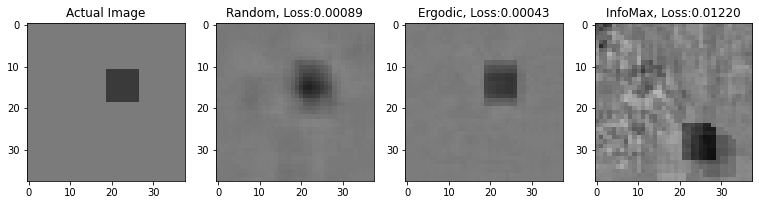

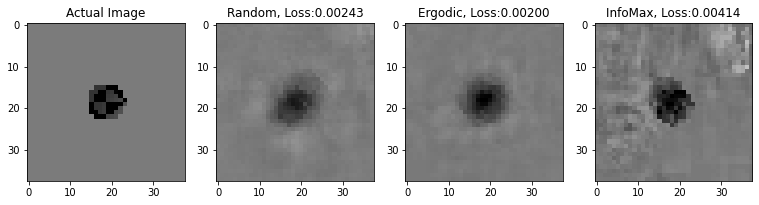

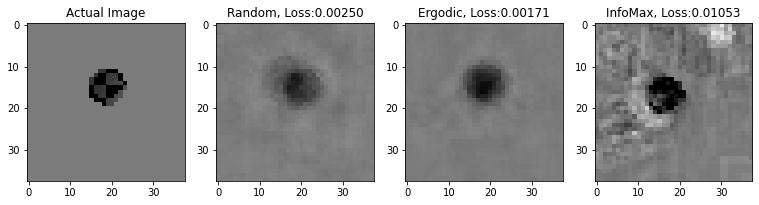

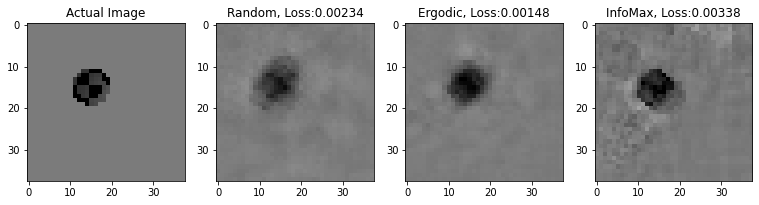

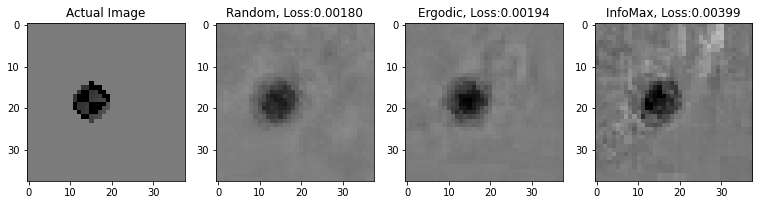

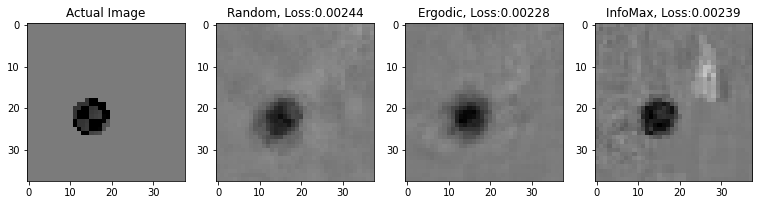

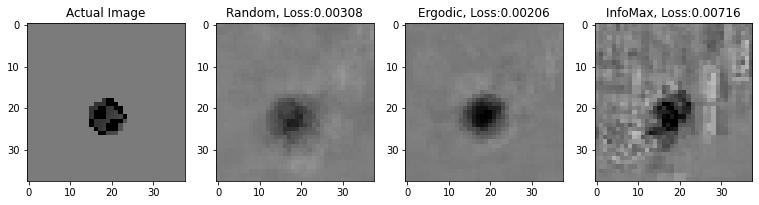

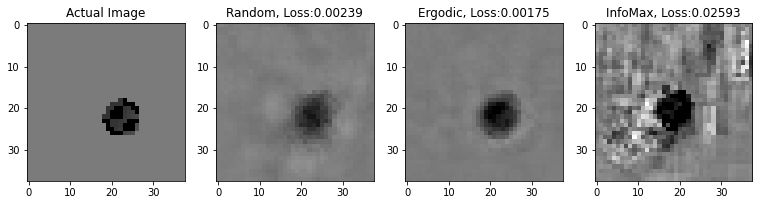

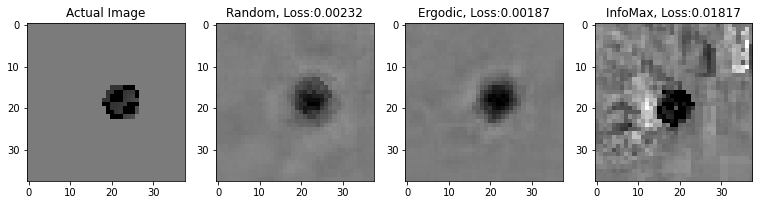

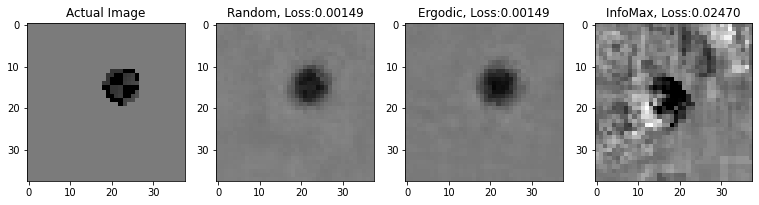

In [56]:
save = True

def mseloss(A,B): return np.square(np.subtract(A, B)).mean()

# sns.set_style("dark")
for i in range(len(testbuffer)):
    fig, axes = plt.subplots(1,4, figsize=(13, 3))
    axes[0].imshow(np.mean(testbuffer[i][1][:,::2,::2],axis=0).T, cmap='gray',vmin=0, vmax=1)
    axes[0].set_title('Actual Image')
    axes[1].imshow((ycheck2[i]), cmap='gray',vmin=0, vmax=1)
    axes[1].set_title("Random, Loss:{:.5f}".format(mseloss(ycheck2[i], np.mean(testbuffer[i][1][:,::2,::2],axis=0).T)))
    axes[2].imshow((ycheck1[i]), cmap='gray',vmin=0, vmax=1)
    axes[2].set_title("Ergodic, Loss:{:.5f}".format(mseloss(ycheck1[i], np.mean(testbuffer[i][1][:,::2,::2],axis=0).T)))
    axes[3].imshow((ycheck3[i]), cmap='gray',vmin=0, vmax=1)
    axes[3].set_title("InfoMax, Loss:{:.5f}".format(mseloss(ycheck3[i], np.mean(testbuffer[i][1][:,::2,::2],axis=0).T)))
    
    if save: plt.savefig("figures/intensity/"+'IC' + str(ic) + '_'+str(i)+"_img_comp.pdf")
 

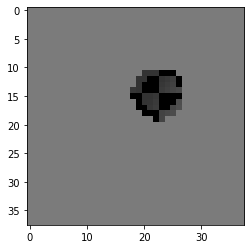

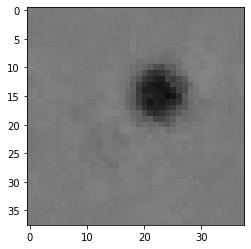

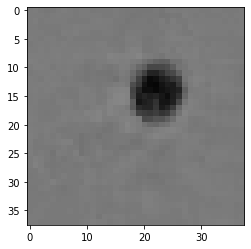

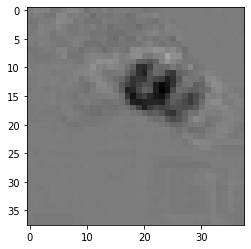

In [7]:
from IPython.display import clear_output

for i in range(int(len(testbuffer)/2)):
    clear_output(wait=True)
    plt.imshow(np.mean(testbuffer[i][1][:,::2,::2],axis=0).T, cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_actual.png")
    plt.show()
    plt.imshow((ycheck2[i]), cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_rand_est.png")
    plt.show()
    plt.imshow((ycheck1[i]), cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_ent_est.png")
    plt.show()
    plt.imshow((ycheck3[i]), cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_im_est.png")
    plt.show()

    
for i in range(9,len(testbuffer)):
    clear_output(wait=True)
    plt.imshow(np.mean(testbuffer[i][1][:,::2,::2],axis=0).T, cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_actual.png")
    plt.show()
    plt.imshow((ycheck2[i]), cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_rand_est.png")
    plt.show()
    plt.imshow((ycheck1[i]), cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_ent_est.png")
    plt.show()
    plt.imshow((ycheck3[i]), cmap='gray',vmin=0, vmax=1)
    if save: plt.savefig("figures/intensity/gifdata/"+str("{:02d}".format(i))+"_im_est.png")
    plt.show()


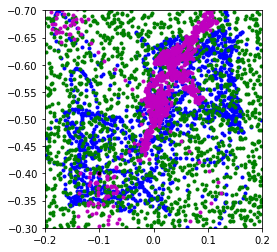

In [8]:
test_env_traj = np.array(test_env_traj)
# sns.set(style='darkgrid')
# Plot Traj
fig = plt.figure()
fig.patch.set_facecolor('white')
env_traj1 = np.array(env_traj1)
plt.plot(env_traj1[:,0], env_traj1[:,2],'b.')
plt.plot(env_traj2[:,0], env_traj2[:,2],'g.')
plt.plot(env_traj3[:,0], env_traj3[:,2],'m.')

plt.plot(obj1[0], obj1[2],'k.')
plt.plot(obj2[0], obj2[2],'g.')
# plt.plot(test_env_traj[:,0], test_env_traj[:,2], 'r.')
plt.axis('square')
plt.xlim(env_lim[0])
plt.ylim(env_lim[1])
plt.show()

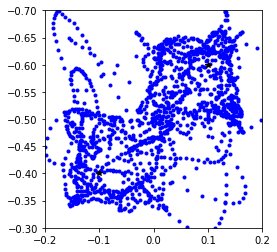

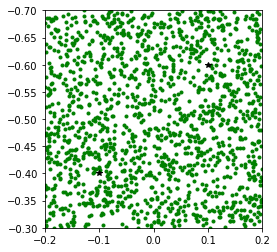

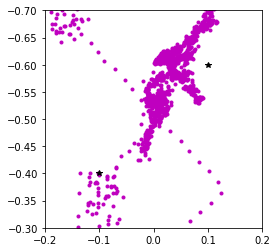

In [9]:
fig = plt.figure()
fig.patch.set_facecolor('white')
env_traj1 = np.array(env_traj1)
plt.plot(env_traj1[:,0], env_traj1[:,2],'b.')

# plt.plot(np.array(test_env_traj)[:,0], np.array(test_env_traj)[:,2], 'r.')
plt.plot(obj1[0], obj1[2],'k*')
plt.plot(obj2[0], obj2[2],'k*')
plt.axis('square')
plt.xlim(env_lim[0])
plt.ylim(env_lim[1])
if save: plt.savefig('figures/intensity/entropy_traj.pdf')#_wtestdata.pdf')
plt.show()

fig = plt.figure()
fig.patch.set_facecolor('white')
env_traj2 = np.array(env_traj2)
plt.plot(env_traj2[:,0], env_traj2[:,2],'g.')

# plt.plot(np.array(test_env_traj)[:,0], np.array(test_env_traj)[:,2], 'r.')
plt.plot(obj1[0], obj1[2],'k*')
plt.plot(obj2[0], obj2[2],'k*')

plt.axis('square')
plt.xlim(env_lim[0])
plt.ylim(env_lim[1])
if save: plt.savefig('figures/intensity/random_traj.pdf')#_wtestdata.pdf')
plt.show()

fig = plt.figure()
fig.patch.set_facecolor('white')
env_traj3 = np.array(env_traj3)
plt.plot(env_traj3[:,0], env_traj3[:,2],'m.')

# plt.plot(np.array(test_env_traj)[:,0], np.array(test_env_traj)[:,2], 'r.')
plt.plot(obj1[0], obj1[2],'k*')
plt.plot(obj2[0], obj2[2],'k*')

plt.axis('square')
plt.xlim(env_lim[0])
plt.ylim(env_lim[1])
if save: plt.savefig('figures/intensity/im_traj.pdf')#_wtestdata.pdf')
plt.show()

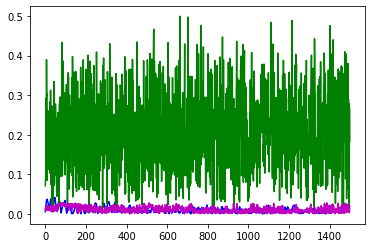

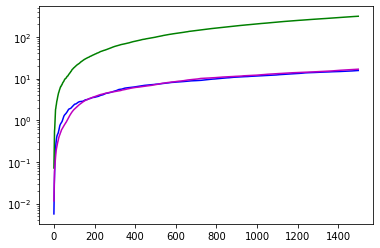

In [10]:
energy1 = [np.linalg.norm(env_traj1[i+1]-env_traj1[i]) for i in range(len(env_traj1)-1)]
plt.plot(energy1,'b')
energy2 = [np.linalg.norm(env_traj2[i+1]-env_traj2[i]) for i in range(len(env_traj2)-1)]
plt.plot(energy2,'g')
energy3 = [np.linalg.norm(env_traj3[i+1]-env_traj3[i]) for i in range(len(env_traj3)-1)]
plt.plot(energy3,'m')

# plt.plot(np.linalg.norm(action2, axis=1))
if save: plt.savefig('figures/intensity/logenergy_vs_time.pdf')
plt.show()
plt.semilogy(np.cumsum(energy1),'b')
plt.semilogy(np.cumsum(energy2),'g')
plt.semilogy(np.cumsum(energy3),'m')

if save: plt.savefig('figures/intensity/logcumenergy_vs_time.pdf')



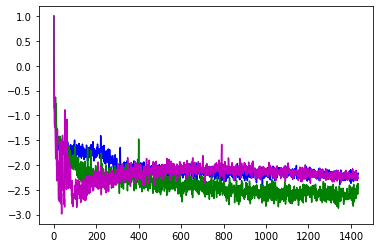

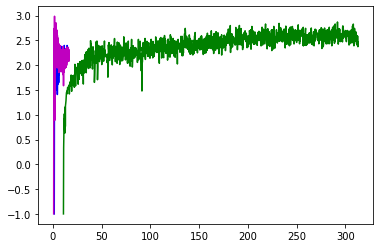

In [11]:
plt.plot(loss1[::10], 'b')
plt.plot(loss2[::10], 'g')
plt.plot(loss3[::10], 'm')

plt.show()

plt.plot(np.cumsum(energy1)[64:],-np.array(loss1[::10]), 'b')
plt.plot(np.cumsum(energy2)[64:],-np.array(loss2[::10]), 'g')
plt.plot(np.cumsum(energy3)[64:],-np.array(loss3[::10]), 'm')

plt.show()


In [12]:
loss1 = []
loss2 = []
loss3 = []
mseloss1 = [None]*len(testbuffer)
mseloss2 = [None]*len(testbuffer)
mseloss3 = [None]*len(testbuffer)

with torch.no_grad():
    for cp in range(50,15400,50):
        PATH =  dir_path1 + "model_checkpoint_iter"+str(cp)+".pth"
        model1.load_state_dict(torch.load(PATH)['state_dict'])
        model1.eval()

        PATH =  dir_path2 + "model_checkpoint_iter"+str(cp)+".pth"
        model2.load_state_dict(torch.load(PATH)['state_dict'])
        model2.eval()

        PATH =  dir_path3 + "model_checkpoint_iter"+str(cp)+".pth"
        model3.load_state_dict(torch.load(PATH)['state_dict'])
        model3.eval()

        xt = np.expand_dims(testbuffer[0][0], axis=0)
        yt = np.expand_dims(np.mean(testbuffer[0][1][:,::2,::2],axis=0).flatten(), axis=0)

        xt = torch.FloatTensor(xt)#.squeeze()
        yt = torch.FloatTensor(yt)#.squeeze()
        _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
        z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

        _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
        z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

        _, _ , z_mu3, z_logvar3, _ = model3(xt, yt)
        z_samples3 = model3.reparameterize(z_mu3, z_logvar3)

        ind = 0
        for i in range(int(len(testbuffer)/2)):

            xc = np.expand_dims(testbuffer[ind][0], axis=0)
            xc = torch.FloatTensor(xc)#.squeeze()

            y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
            img_pred1 = y_pred[:,1:]
            ycheck1 = img_pred1[0].detach().numpy().reshape((38,38)).T
            mseloss1[ind] = mseloss(ycheck1, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)


            y_pred = model2.decode(torch.cat([z_samples2, xc], dim=1))
            img_pred2 = y_pred[:,1:]
            ycheck2 = img_pred2[0].detach().numpy().reshape((38,38)).T
            mseloss2[ind] = mseloss(ycheck2, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)

            y_pred = model3.decode(torch.cat([z_samples3, xc], dim=1))
            img_pred3 = y_pred[:,1:]
            ycheck3 = img_pred3[0].detach().numpy().reshape((38,38)).T
            mseloss3[ind] = mseloss(ycheck3, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)
            ind +=1

        xt = np.expand_dims(testbuffer[ind][0], axis=0)
        yt = np.expand_dims(np.mean(testbuffer[ind][1][:,::2,::2],axis=0).flatten(), axis=0)

        xt = torch.FloatTensor(xt)#.squeeze()
        yt = torch.FloatTensor(yt)#.squeeze()

        _, _ , z_mu1, z_logvar1, _ = model1(xt, yt)
        z_samples1 = model1.reparameterize(z_mu1, z_logvar1)

        _, _ , z_mu2, z_logvar2, _ = model2(xt, yt)
        z_samples2 = model2.reparameterize(z_mu2, z_logvar2)

        _, _ , z_mu3, z_logvar3, _ = model3(xt, yt)
        z_samples3 = model3.reparameterize(z_mu3, z_logvar3)

        for i in range(int(len(testbuffer)/2)):
            xc = np.expand_dims(testbuffer[ind][0], axis=0)
            xc = torch.FloatTensor(xc)#.squeeze()

            y_pred = model1.decode(torch.cat([z_samples1, xc], dim=1))
            img_pred1 = y_pred[:,1:]
            ycheck1 = img_pred1[0].detach().numpy().reshape((38,38)).T
            mseloss1[ind] = mseloss(ycheck1, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)

            y_pred = model2.decode(torch.cat([z_samples2, xc], dim=1))
            img_pred2 = y_pred[:,1:]
            ycheck2 = img_pred2[0].detach().numpy().reshape((38,38)).T
            mseloss2[ind] = mseloss(ycheck2, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)

            y_pred = model3.decode(torch.cat([z_samples3,xc], dim=1))
            img_pred3 = y_pred[:,1:]
            ycheck3 = img_pred3[0].detach().numpy().reshape((38,38)).T
            mseloss3[ind] = mseloss(ycheck3, np.mean(testbuffer[ind][1][:,::2,::2],axis=0).T)

            ind += 1
            
        loss1.append(mseloss1.copy())
        loss2.append(mseloss2.copy())
        loss3.append(mseloss3.copy())


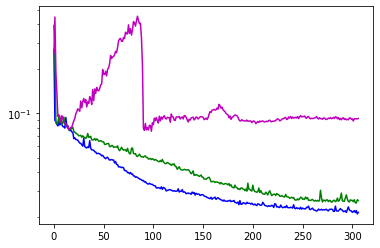

In [13]:
loss1 = np.array(loss1)
loss2 = np.array(loss2)
loss3 = np.array(loss3)

plt.semilogy(np.sum(loss1, axis=1), 'b')
plt.semilogy(np.sum(loss2, axis=1),'g')
plt.semilogy(np.sum(loss3, axis=1),'m')

if save: plt.savefig('figures/intensity/logtestinglossovertime.pdf')
plt.show()


